In [220]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pandas as pd

In [2]:
#%pip install -U xarray

og_data = xr.open_dataset('/home/jovyan/work/files/data/ARTS_OSO_LwC.nc')

df_og = og_data.to_dataframe() #original df
df_og = df_og.reset_index()

# Data as per "Forkman, P., Flygare, J., & Elgered, G. (2021)'s" readme.txt
# time      5840x1        Hours since 2000-01-01 00:00:0.0. There is one 
#                          measurement every 6 hour, which gives 4 years of data
# Am           1x6        Airmass 1:1:6 (-) defined as 1/sin(elevation)             
# F            1x131      Frequencies 14:0.2:40 (GHz)     

# P         5840x1        Ground pressure, P(time) (Pa)    
# T         5840x1        Ground temperature, T(time) (K)            
# RH        5840x1        Ground relative humidity, RH(time) (0-1)    
# Tb        5840x131x6    Brightness temperature, Tb(time, F, Am) (K)              
# Tr        5840x131x6    Transmission (-), Tr(time, F, Am) defined as exp(-tau)
# ZWD       5840x1        Zenith wet delay, ZWD(time) (mm) *
# WVP       5840x1        Water vapour path, WVP(time) (mm) *
# LWP       5840x1        Liquid water path, LWP(time) (mm)


# Context: this study (with AI coniderably aiding my understanding) appears to 
#          be about improving the precision of geodesic measures, such as 
#          tectonic movements, (Earth's rotation(?)) ------.
#          These measures are done by capturing raido wave electromagnetic radiation
#          signals, from quasars far away, using radio telescopes, with the
#          VLBI (Very Long Baseline Interferometry) technique. The issue is that once
#          the signal that is being measured arrives to the Earth's atmosphere, 
#          it gets slowed down by the water vapor, which is differently abundant
#          between telescopes. This makes considerably affects the (extremely
#          precise) distance measurements. The current approach is to correct this
#          delay by using water vapor rediometers and estimate the water vapor
#          (an imperfect approach). The study suggest a novel one, potentially more
#          accurate.


In [3]:
df_og['time'].value_counts()

time
2000-01-01 00:00:00    786
2000-01-01 06:00:00    786
2000-01-01 12:00:00    786
2000-01-01 18:00:00    786
2000-01-02 00:00:00    786
                      ... 
2003-12-29 18:00:00    786
2003-12-30 00:00:00    786
2003-12-30 06:00:00    786
2003-12-30 12:00:00    786
2003-12-30 18:00:00    786
Name: count, Length: 5840, dtype: int64

In [4]:
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000

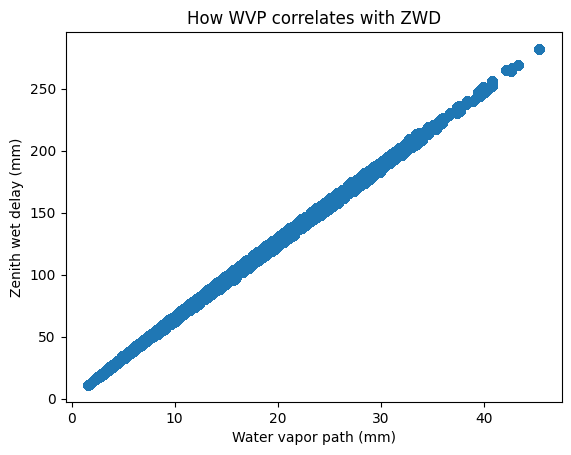

In [8]:
#Let's check how water vapour affects the (Zeith wet) delay!
fig, ax = plt.subplots()
    
my_plot = plt.scatter(df_og['WVP'], df_og['ZWD'])
plt.title("How WVP correlates with ZWD")
plt.xlabel("Water vapor path (mm)")
plt.ylabel("Zenith wet delay (mm)")
plt.show()

In [ ]:
# Conclusion: Zenith wet delay seems deeply correlated with the amount of water vapor in the atmosphere.

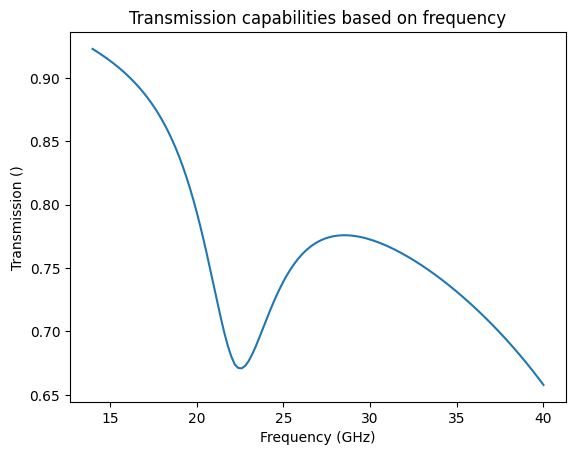

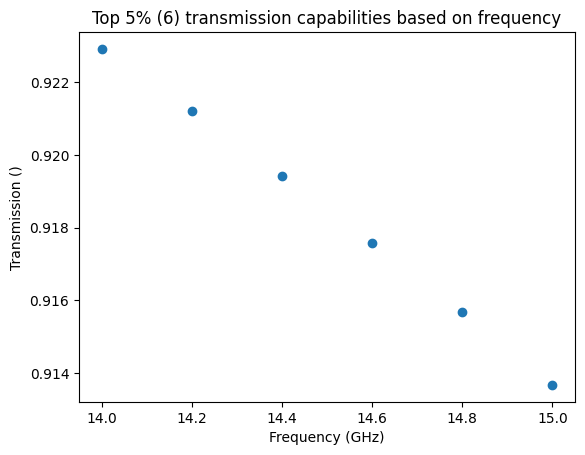

np.float64(14.0)

In [110]:
# "What frequencies should we use for satellite communications to minimize atmospheric losses?"
# To check which frequencies the telescopes should use to maximise their 
# transmission, let's plot transmission against frequency.
df = df_og.copy(deep=True)
df = df.groupby(by=['F'], as_index=False)['Tr'].mean().rename(columns={'Tr':'Tr_mean'}, inplace=False)


my_plot = plt.plot(df['F'], df['Tr_mean'])
plt.title('Transmission capabilities based on frequency')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission ()')
plt.show()


# Let's plot only the top 5% frequencies.
num_frequencies = df.shape[0]
wanted_num_frequencies = int(np.floor(num_frequencies * 0.05)) #5% 
df = df.nlargest(wanted_num_frequencies, "Tr_mean")
my_plot = plt.scatter(df['F'], df['Tr_mean'])
plt.title('Top 5% (6) transmission capabilities based on frequency')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission ()')
plt.show()
df = df.nlargest(1, "Tr_mean")
best_f = df['F'].iat[0] #frequency with highest avg transmition rate
df.style

In [ ]:
# Conclusion: the frequencies that maximise transmission capabilities are in the 14-15GHz range, with the best being 14GHz!

Minimum transmition rate: 0.4096.


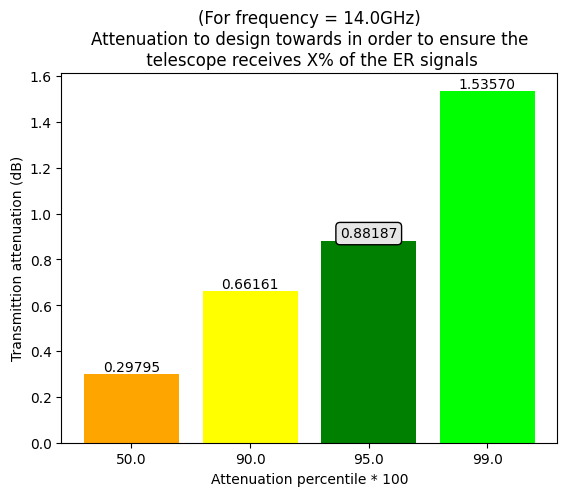

In [158]:
# Now we could think "So let's assume we use the best frequency, even that one still has cases where
#  the received transmission percentage is low, right?" 
# Let's see 
print(f"Minimum transmition rate: {df_og[(df_og['F'] == best_f)]['Tr'].min():.4f}.")

# Yup, it goes all the way down to ~41%. So if we wanted to adapt the telescope
#  for at least 95% (of the best) scenarios (failing 5% when the transmission is on
#  the low end), to what attenuation dBs threshold should we design it to?

# Note: Attenuation is the loss of a force, effect or value, such as the loss of
#       a signal amplitude. It is measured in decibels.
#       Att = -10 * log10(Tr)
df = df_og[(df_og['F'] == best_f)]['Tr'].copy(deep=True)
df_att = (-10) * np.log10(df) # lower is better

# Let's assess some options of availability (percentiles) we could build for:
percentiles_colours = {
         0.5 : "orange",
         0.9: "yellow",
         0.95: "green" ,
         0.99: "lime"
     } #desired availability


# Plot attenuation against the ER signal capture availability
fig, ax = plt.subplots()
for i, percentile in enumerate(percentiles_colours):
    att_threshold = df_att.quantile(percentile)
    plt.bar(x=str(percentile*100), height=att_threshold, color=percentiles_colours[percentile], width=0.8)
    plt.bar_label(
            ax.containers[i], labels=[f"{att_threshold:.5f}"],
            bbox=dict(boxstyle="round", fc="0.9") if percentile==0.95 else None
        )
plt.title(f"(For frequency = {best_f}GHz)\nAttenuation to design towards in order to ensure the\n telescope receives X% of the ER signals")
plt.xlabel(f"Attenuation percentile * 100")
plt.ylabel(f"Transmittion attenuation (dB)")

plt.show()

In [81]:
# Conclusion: telescopes should be designed to account for ~0.882 attenuation in
#             order to receive 95% of the electromagnetic radiation signals that
#             arrive, making it resilient to the factors that introduce Tr variability

0.40957458511305816

           P         T        RH        Tr
P   1.000000 -0.044398 -0.204126  0.243435
T  -0.044398  1.000000 -0.178858 -0.113128
RH -0.204126 -0.178858  1.000000 -0.304170
Tr  0.243435 -0.113128 -0.304170  1.000000


<Axes: >

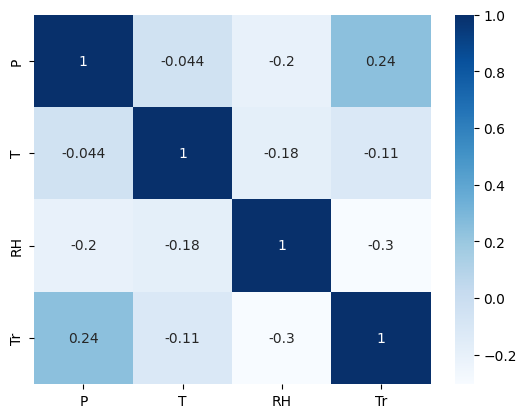

In [171]:
# Using a certian frequency, could we predict transmission rates based on weather
# conditions (ground pressure, temperature and relative humidity)?
#
# Let's get an idea
df = df_og[df_og['F']==best_f][['P', 'T', 'RH', 'Tr']].copy(deep=True)
corr = df.corr() # variables' corelations
print(corr)
sns.heatmap(corr, cmap="Blues", annot=True)

In [172]:
# At first glance, ground pressure, temperature and relative humidy do not seem 
# very correlated with the transmission rate. They may also not be redundant
# as they appear to have a modest correlation with each other.
#
# Let's see what a model can do!

,P,T,RH,Tr
0,101405.351637,275.233297,0.982321,0.974639
1,101157.621343,274.830474,0.957170,0.970692
2,100915.671422,275.592061,1.006459,0.937067
3,101165.741391,276.678843,0.976453,0.975315
4,101388.010516,276.559255,0.971590,0.982940
...,...,...,...,...
3831035,100129.127738,273.974476,0.655237,0.920446
3831036,100477.051173,275.052866,0.721762,0.905284
3831037,100742.948356,274.039515,0.971299,0.901728
3831038,101096.927421,274.222044,0.966588,0.917734


In [179]:
# Train/test split
target_var = 'Tr'
df_target_var = df[target_var]
df_predictors = df.drop(columns=[target_var], inplace=False)
X_train, X_test, y_train, y_test = ms.train_test_split(df_predictors, df_target_var, test_size=0.2, random_state=42)

In [191]:
# Scale the data features (pressure and temperature have values far larger than RH and Tr)
#  Method: mean normalisation (slightly more resilient to any possible outliers than min-max)
X_train = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.mean()) / (X_test.max() - X_test.min())
X_train

,P,T,RH
768484,0.029013,0.085822,-0.365237
1532714,0.064358,0.082530,0.068179
5094,0.084595,0.275504,-0.294936
3829269,0.067068,-0.077149,0.009289
769194,0.106129,-0.132030,-0.112389
...,...,...,...
1535250,0.068740,0.371991,-0.135083
765465,-0.169653,-0.100161,0.182005
770484,-0.281985,0.233056,0.012794
860,-0.019542,0.172919,0.066799


In [218]:
# Model hyperparameters
random_forests_r_model = RandomForestRegressor(
        n_estimators=100,
        criterion='squared_error',
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )

# Fit the data
random_forests_r_model.fit(X_train, y_train.values.ravel())

# Predict
if type(y_train) == pd.Series:
    y_train = y_train.to_frame()
    y_test = y_test.to_frame()
y_pred = pd.DataFrame(columns=y_test.columns, index=y_test.index)
y_pred[target_var] = random_forests_r_model.predict(X_test)
y_pred

,Tr
770556,0.935447
3063343,0.948394
2445,0.850720
1533049,0.914689
3828699,0.914273
...,...
768244,0.948475
1533676,0.939431
3023,0.950678
3828096,0.870982


In [237]:
# Let's check how our model did!
# Metric: RMSE
rmse = metrics.root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
# Metric: MAPE
#mape = (metrics.mean_absolute_error(y_test, y_pred) - y_test) * 100
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2) 
print(f"MAPE(%): {mape} -> \"accuracy:\" {100-mape}%")

RMSE: 0.0479
MAPE(%): 4.12 -> "accuracy:" 95.88%


In [ ]:
# Conclusion: Transmission rate is predictable with ~96% accuracy from 
#             the ground pressure, temperate and relative humidity!

In [240]:
# Which features contributed the most for our predictions?
feature_importances = random_forests_r_model.feature_importances_
feature_importances

array([0.30973328, 0.26972815, 0.42053857])

In [ ]:
# Conclusion: the features that most contributed to predicting the Tr's behaviour
#             were, in order, Rh, P and T. Notice how this mathes the order of
#             the absolute value of the correlations we have in our heatmap!